# Analysis of Yoga Tweets
1. Collect tweets from MongoDB, clean them up, make some plots.
2. Define tokenize and stem functions, plus list of stop words.
3. Apply Tf-Idf transformation, and compute matrix of cosine-similarity distances.
4. Perform multidimensional scale (MDS) transformation.
5. Plot the result of MDS.
6. Apply K-Means clustering with pre-specified number of clusters, and visualize result with MDS.
7. Apply LDA transformation with pre-specified number of topics, and with or without topic seeding.
8. Visualize result of LDA transformation with MDS.

Total number of tweets = 10138

Most Frequent Tweets:
--------------------------------------------------------------------------------
238: "@mohitfreedom: #LetsStayfree and be #SultansOfStyle at @IndianEmbassyUS Yoga Day celebrations of PM of #India @narendramodi "
149: "@bitchprblmz:  quits school and becomes that Instagram hoe that's always traveling to exotic places and doing yoga "
112: "@MissRBaller: You asked for it, so I forced her to do it  The Yoga Challenge with my mommy!!!!!! She's a trooper @pixietangerine "
106: "@Rharrna: Khlo Kardashian Booty Looks So Hot In Tight Yoga Pants They Fit So Well "
94: "8 places to practice hot yoga  Indianapolis Star "
61: "@OMGtrolls: i didn't realize how good i was at yoga i do number 13 all the time "
53: "@xxochristinaxo: kim k   looks so good in yoga pants  that ass is crazy     "
48: "@thenewgabriel: i didn't realize how good i was at yoga i do number 13 all the time "
46: "@BIackChyna: Omg! Selena Gomez butt is so huge in yoga pants 

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


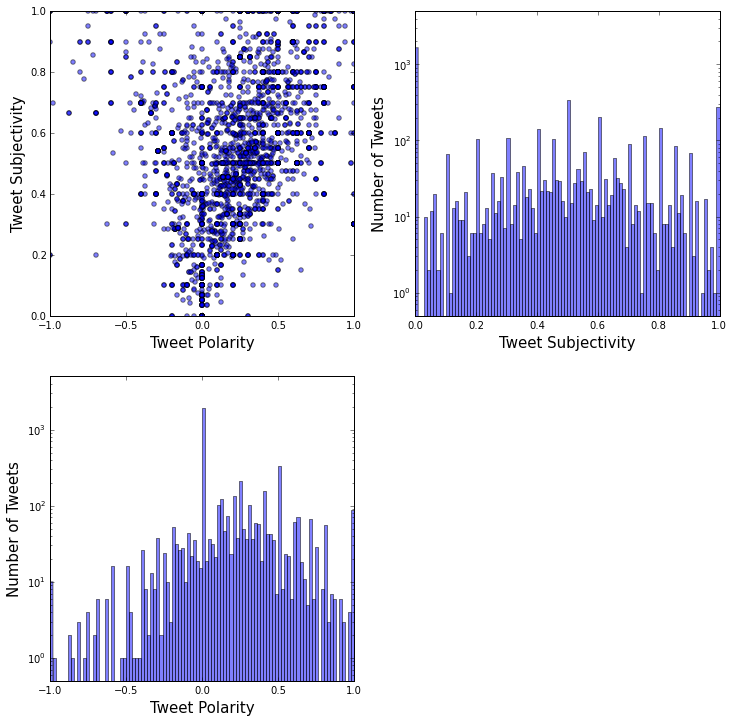

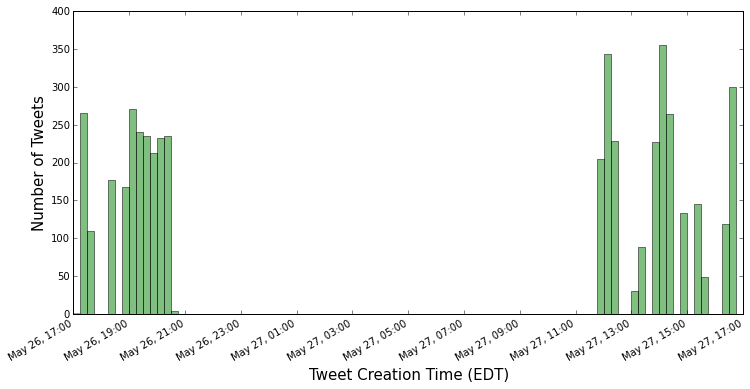

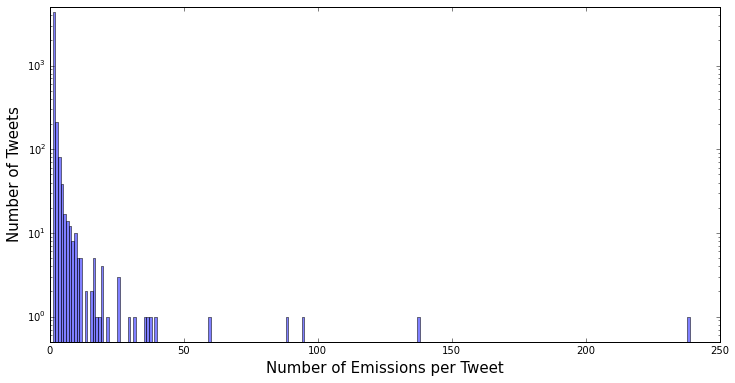

In [1]:
'''
Make a list of the tweets we'll be analyzing.
The content of stored tweets is illustrated by the following example:
{'polarity':       0.375, 
 'retweet_count':  0, 
 'sentiment':     'positive', 
 'author':        'allyyreaad', 
 'time':          'Tue May 26 21:16:47 +0000 2015', 
 'location':       None, 
 'subjectivity':   0.75, 
 'message':       'So excited to go to yoga tonight \u263a\ufe0f', 
 '_id':            ObjectId('5564e2c0fe38ad069086a0ae'), 
 'favorite_count': 0}
'''
from   pymongo import MongoClient
from   guess_language import guessLanguage
from   dateutil import parser
from   dateutil.relativedelta import relativedelta
import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

client = MongoClient()
yoga   = client.dsbc.yoga
print('Total number of tweets = %i' %yoga.count())

cursor   = yoga.find()
ctweets  = [] # cleaned-up tweets
nrtweets = 0
dt0      = parser.parse('Jan 01 00:00:00 +0000 2016')
dt1      = parser.parse('Jan 01 00:00:00 +0000 2015')
for record in cursor:
    text         = record["message"]
    polarity     = record["polarity"]
    subjectivity = record["subjectivity"]
    time         = record["time"]
    dt           = parser.parse(time)
    dt0          = dt if dt<dt0 else dt0
    dt1          = dt if dt>dt1 else dt1
    fav_count    = record["favorite_count"]
    retw_count   = record["retweet_count"]

    # Remove emojis:
    try:
        # Wide UCS-4 build
        emoji = re.compile(u'['u'\U0001F300-\U0001F64F'
                           u'\U0001F680-\U0001F6FF'
                           u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
    except re.error:
        # Narrow UCS-2 build
        emoji = re.compile(u'('u'\ud83c[\udf00-\udfff]|'
                           u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
                           u'[\u2600-\u26FF\u2700-\u27BF])+', re.UNICODE)
    text = emoji.sub('', text)
    
    # Remove URL's:
    text = re.sub(r"http\S+", "", text)
    
    # Remove html ampersands:
    text = re.sub(r"&amp;", "and", text)
    
    # Remove unicode literals:
    text = text.encode('ascii','ignore')
    
    # Replace some special characters with spaces:
    rx   = '['+re.escape(''.join('*_~^.'))+']'
    text = re.sub( rx, ' ', text )
    text = text.replace("\n"," ")
    
    # Replace dash at beginning of tweet, or at beginning of a word in the tweet, with a space:
    text = re.sub(r"\A-| -(?=.)"," ", text)
    
    # Remove retweet tag:
    if text[0:3] == "RT ":
        text = text[3:]
    
    # Check language:
    lngg = guessLanguage(text)
    
    # Save cleaned-up tweet:
    if lngg == "en":
        ctweets.append([text,polarity,subjectivity,dt])

# Group tweets by message:
utweets = {}
for tweet in ctweets:
    utweets.setdefault(tweet[0],[tweet[1],tweet[2],[]])[2].extend([tweet[3]])

# List the top tweets by emission frequency:
print('\nMost Frequent Tweets:\n%s' %("-"*80))
ttweets = []
for (message,features) in utweets.items():
    if len(features[2])>=20:
        ttweets.append([message,len(features[2])])
ttweets = sorted(ttweets,key=lambda x: x[1],reverse=True)
for tweet in ttweets:
    print('%i: "%s"' %(tweet[1],tweet[0]))
print('%s\n' %("-"*80))

# Tally the tweets by polarity and subjectivity:
npos           = sum(1 for feature in utweets.values() if feature[0]>0)
nneg           = sum(1 for feature in utweets.values() if feature[0]<0)
nneu           = sum(1 for feature in utweets.values() if feature[0]==0)
sub0           = sum(1 for feature in utweets.values() if feature[1]==0)
pol0_sub0      = sum(1 for feature in utweets.values() if feature[0]==0 and feature[1]==0)

# Make some lists for later plotting.
tweets         = [tweet for tweet in utweets.keys()] # all tweets
polarities     = [feature[0] for feature in utweets.values()]
subjectivities = [feature[1] for feature in utweets.values()]
dts            = [dt for feature in utweets.values() for dt in set(feature[2])]
dt0s           = [feature[2][0] for feature in utweets.values()]
n_emissions    = [len(set(feature[2])) for feature in utweets.values()]

ptweets        = [tweet for (tweet,feature) in utweets.items() if feature[0]>0] # positive-sentiment tweets
otweets        = [tweet for (tweet,feature) in utweets.items() if feature[0]<=0]# neutral and negative-sentiment tweets
assert npos==len(ptweets)
assert nneg+nneu==len(otweets)

print('All tweets were created between %s (UTC) and %s (UTC).' \
      %(dt0.strftime("%a %B %d, %Y, at %H:%M:%S"),dt1.strftime("%a %B %d, %Y, at %H:%M:%S")))
print('Number of tweets after language filter =   %i' % len(ctweets))
print('Total number of distinct tweet times = %i' %len(dts))
print('Number of tweets after duplicate removal = %i; pos=%i, neg=%i, neu=%i' % (len(utweets),npos,nneg,nneu))
print('Number of tweets with zero subjectivity = %i' %sub0)
print('Number of tweets with zero subjectivity and zero polarity = %i' %pol0_sub0)

# Make some plots
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(12,12) )
axes[0,0].scatter(polarities,subjectivities,alpha=0.5)
axes[0,0].set_xlabel("Tweet Polarity",fontsize=15)
axes[0,0].set_xlim(-1.0,1.0)
axes[0,0].set_ylabel("Tweet Subjectivity",fontsize=15)
axes[0,0].set_ylim(0.0,1.0)
axes[0,1].hist(subjectivities,bins=100,range=[0.0,1.0],alpha=0.5)
axes[0,1].set_xlabel("Tweet Subjectivity",fontsize=15)
axes[0,1].set_ylabel("Number of Tweets",fontsize=15)
axes[0,1].set_yscale("log")
axes[0,1].set_ylim(0.5,5000.0)
axes[1,0].hist(polarities,bins=100,range=[-1.0,1.0],alpha=0.5)
axes[1,0].set_xlabel("Tweet Polarity",fontsize=15)
axes[1,0].set_ylabel("Number of Tweets",fontsize=15)
axes[1,0].set_yscale("log")
axes[1,0].set_ylim(0.5,5000.0)
axes[1,1].axis("off")
plt.show()
#fig.savefig('Subj_vs_Pol.png', dpi=200)

mytimes = [dt.day+dt.hour/24.+dt.minute/1440.+dt.second/86400. for dt in dt0s]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,6) )
xlim1   = 26.+21./24.
xlim2   = xlim1+1.0
ax.hist(mytimes,bins=np.arange(xlim1,xlim2,1./96.),color='g',alpha=0.5)
ax.set_xlabel("Tweet Creation Time (EDT)",fontsize=15)
ax.set_xlim(xlim1,xlim2)
xticks = [xlim1+ind*(xlim2-xlim1)/12 for ind in range(13)]
dt0    = parser.parse('May 26 17:00:00 +0000 2015') # Starting UTC is 21:00, which is 17:00 EDT
delta  = relativedelta(**{'hours':2})
xticklabels = [(dt0+ind*delta).strftime("%B %d, %H:%M") for ind in range(13)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel("Number of Tweets",fontsize=15)
fig.autofmt_xdate() # Rotate x-axis tick labels
plt.show()
#fig.savefig('Tweet_Times.png', dpi=200)

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(12,6) )
ax.hist(n_emissions,bins=250,range=[0.0,250.0],alpha=0.5)
ax.set_xlabel("Number of Emissions per Tweet",fontsize=15)
ax.set_ylabel("Number of Tweets",fontsize=15)
ax.set_yscale("log")
ax.set_ylim(0.5,5000.0)
plt.show()
#fig.savefig('Tweet_Emissions.png', dpi=200)

In [2]:
'''
Load nltk's English stopwords as well as its stemmer, then define:
* tokenize_and_stem: to tokenize into sentences, then words, 
  and return the stems of the words;
* tokenize_only: to only tokenize

Also create a stemmed version of the list of stopwords.  Note that the order 
of operations matters: (filter,stem) is not the same as (stem,filter), where "filter"
means "remove stopwords" in the first case and "remove stemmed stopwords" in the 
second.  For example, the word "willing" is not a stopword, but its stem "will" is.  
Thus, the order (stem,filter) tends to eliminate more tokens than (filter,stem).

Finally, create a dictionary that allows us to go back from stem to word (a one-to-many 
relationship that we arbitrarily reduce to a one-to-one relationship to facilitate 
interpretation of results later.)
'''
import nltk
from   nltk.stem.snowball import SnowballStemmer
from   more_itertools import unique_everseen

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(u'\u0027s')
stopwords.append(u'n\u0027t')
stopwords.append(u'\u0027m')
stopwords.append("'re")
stopwords.append("'ve")
print('Stop words (%i): \n%s\n' %(len(stopwords),[str(word) for word in stopwords]))

stemmer           = SnowballStemmer("english")
stemmed_stopwords = list(unique_everseen([stemmer.stem(word) for word in stopwords]))
print('Stemmed stop words (%i): \n%s\n' %(len(stemmed_stopwords),[str(word) for word in stemmed_stopwords]))

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# Process the tweets:
tokenized_tweets = [tokenize_only(tweet) for tweet in tweets]
stemmed_tweets   = [[stemmer.stem(word) for word in tweet] for tweet in tokenized_tweets]
filtered_tweets  = [[word for word in tweet if word not in stemmed_stopwords] for tweet in stemmed_tweets]

print('Example tweet after tokenization, stemming, and filtering:')
ind = 0
print(tokenized_tweets[ind])
print(stemmed_tweets[ind])
print(filtered_tweets[ind])
print(' ')

# Create a vocabulary to convert stems back to words:
vocab = {}
assert len(tokenized_tweets) == len(stemmed_tweets), 'Tokenized tweets: %i, Stemmed tweets: %i'\
                                                     %(len(tokenized_tweets),len(stemmed_tweets))
for tokenized_tweet,stemmed_tweet in zip(tokenized_tweets,stemmed_tweets):
    assert len(tokenized_tweet) == len(stemmed_tweet), \
            'Tweet length error:\n   tokenized tweet: "%s"\n   stemmed tweet: "%s"' %(tokenized_tweet,stemmed_tweet)
    for word,stem in zip(tokenized_tweet,stemmed_tweet):
        if stem not in stemmed_stopwords:
            vocab.setdefault(stem,word)
        
print('Length of vocabulary = %i' %len(vocab))
print('Vocabulary Extract:\n %s' %([': '.join((str(key),value)) for (key,value) in vocab.items()[-50:]]))

Stop words (132): 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', '

In [3]:
'''
Apply tfidf transformation and compute cosine similarity matrix.
max_df = maximum fraction of documents containing the word, for the word to be included in tfidf matrix
min_df = minimum fraction ...
ngram_range: We'll look at unigrams, bigrams and trigrams.
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from __future__ import print_function

tfidf_vectorizer = TfidfVectorizer( max_df=0.80, max_features=200000, min_df=0.01, stop_words=stemmed_stopwords,
                                    analyzer='word', use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)
dist  = 1 - cosine_similarity(tfidf_matrix)  # Matrix with cosine similarities between all tf-idf vectors
terms = tfidf_vectorizer.get_feature_names()
idf   = tfidf_vectorizer.idf_

print('\nNumber of documents = %i, Number of TF-IDF features = %i' %(tfidf_matrix.shape[0],tfidf_matrix.shape[1]))
print('\nTF-IDF features, with scores:')
for ind,(name,score) in enumerate(zip(terms,idf)):
    if ind%4 != 3:
        print('{2:3d}. {0:17} {1:.2f} | '.format(str(name)+':',score,ind),end='')
    else:
        print('{2:3d}. {0:17} {1:.2f}'.format(str(name)+':',score,ind))

CPU times: user 3.39 s, sys: 495 ms, total: 3.88 s
Wall time: 3.55 s

Number of documents = 4779, Number of TF-IDF features = 127

TF-IDF features, with scores:
  0. back:             4.89 |   1. beach:            5.56 |   2. beauti:           5.43 |   3. beginn:           5.52
  4. best:             5.09 |   5. better:           5.46 |   6. bodi:             4.62 |   7. book:             5.56
  8. ca:               5.27 |   9. challeng:         5.41 |  10. check:            5.21 |  11. class:            3.48
 12. come:             4.55 |  13. day:              3.88 |  14. even:             5.41 |  15. ever:             5.56
 16. everi:            5.21 |  17. exercis:          5.21 |  18. feel:             5.12 |  19. find:             5.50
 20. first:            5.14 |  21. fit:              4.20 |  22. flow:             5.45 |  23. follow:           5.36
 24. free:             4.43 |  25. friend:           5.45 |  26. get:              3.99 |  27. girl:             5.02
 28. go:     

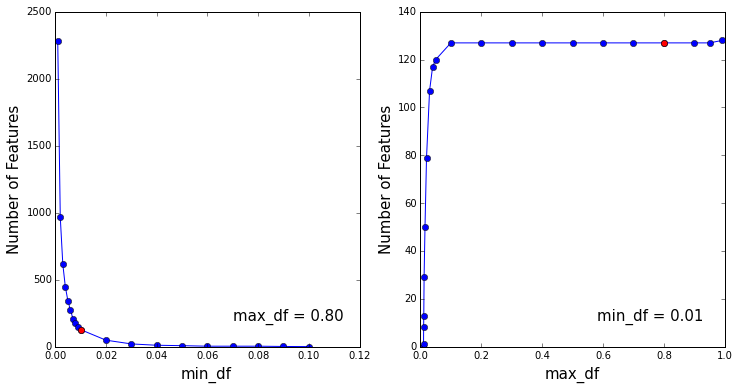

In [4]:
'''
Plot of the number of features as a function of min_df and max_df in the call to TfidfVectorizer
'''
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
mindf = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
nfeat = [2282,966,615,446,343,273,209,175,144,127,48,20,10,7,3,3,3,1,0]
ax[0].plot( mindf, nfeat, marker='o', markerfacecolor='b', linestyle='-', color='b', alpha=1.0 )
ax[0].plot( 0.01, 127, marker='o', markerfacecolor='r', alpha=1.0 )
ax[0].set_xlabel('min_df', fontsize=15)
ax[0].set_ylabel('Number of Features', fontsize=15)
ax[0].text(0.07,200.0,'max_df = 0.80',fontsize=15)
maxdf = [0.01,0.0102,0.0105,0.011,0.012,0.015,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
nfeat = [0,1,8,13,29,50,79,107,117,120,127,127,127,127,127,127,127,127,127,127,128]
ax[1].plot( maxdf, nfeat, marker='o', markerfacecolor='b', linestyle='-', color='b', alpha=1.0 )
ax[1].plot( 0.80, 127, marker='o', markerfacecolor='r', alpha=1.0 )
ax[1].set_xlabel('max_df', fontsize=15)
ax[1].set_ylabel('Number of Features', fontsize=15)
ax[1].text(0.58,11.2,'min_df = 0.01',fontsize=15)
plt.show()
fig.savefig('tfidf_features.png', dpi=200)

## Multidimensional Scaling

In [5]:
'''
We will use multidimensional scaling (MDS) to visualize the result of clustering methods (see below).
This visualization will be in two dimensions, using the distance matrix just computed.  In the call 
to MDS we'll specify random_state so as to make the plots reproducible.

Here we calculate the coordinates of the tweets from the MDS fit.  This is very time consuming.
Here are some numbers (for n_components=2,metric=True,dissimilarity='precomputed',random_state=2,
n_init=4):
Final stress value = 1,973,282.0, Total CPU time = 2min 40s,     for max_iter=30;
Final stress value = 1,868,655.1, Total CPU time = 25min,        for max_iter=300;
Final stress value = 1,832,903.3, Total CPU time = 1h 18min 44s, for max_iter=1000;
Final stress value = 1,831,327.8, Total CPU time = 2h 8min,      for max_iter=6000.
When using the distance matrix obtained from TfIdf with use_idf=False, the numbers are as follows:
Final stress value = 1,952,848.8, Total CPU time = 2min 35s,     for max_iter=30;
Final stress value = 1,836,924.5, Total CPU time = 20min 36s,    for max_iter=300;
Final stress value = 1,808,119.9, Total CPU time = 1h 21min 24s, for max_iter=1000;
Final stress value = 1,803,463.4, Total CPU time = 2h 7min 55s,  for max_iter=6000.
'''
from   sklearn.manifold import MDS
import pickle

refit    = False
pkl_file = "results/yoga_tweets_mds_2_i6000.pkl"
if refit:
    MDS()
    mds = MDS(n_components=2, metric=True, dissimilarity="precomputed", random_state=2, 
              n_init=4, max_iter=6000, verbose=1)
    %time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    print('Final stress value: %f' %mds.stress_)
    with open( pkl_file, 'w' ) as f:
        pickle.dump(pos, f)
else:
    with open( pkl_file, 'r' ) as f:
        pos = pickle.load(f)
    print('Number of tweets in MDS fit: %i' %len(pos))
    
xs, ys = pos[:, 0], pos[:, 1]

Number of tweets in MDS fit: 4779


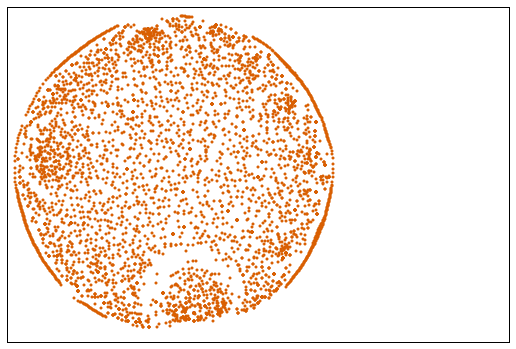

In [73]:
'''
Plot the data without clusters first.
'''
fig, ax = plt.subplots(figsize=(9, 6))
#fig, ax = plt.subplots(figsize=(6,6))
ax.margins(0.05) # Add 5% padding to the autoscaling
ax.plot( xs, ys, marker='o', linestyle='', ms=3, color='#d95f02', alpha=1.0, mec="none" ) 
ax.set_aspect('auto')
ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
ax.set_xlim(-0.85,1.7)
ax.set_ylim(-0.85,0.85)

plt.show()
fig.savefig('mds_tweet_space.png', dpi=200)

Number of points with distance not equal to 1: 2614


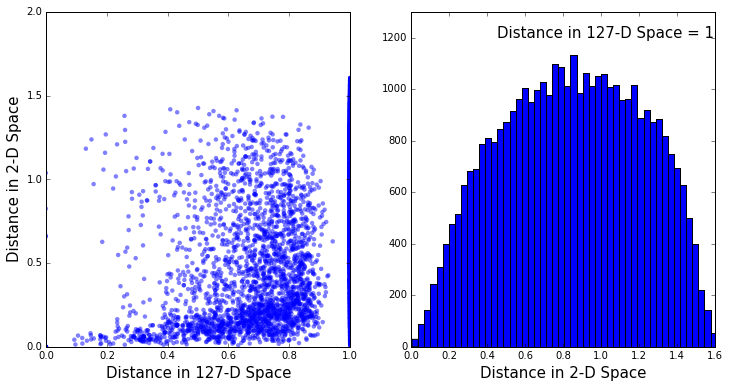

Number of points selected for distance plot: 15510


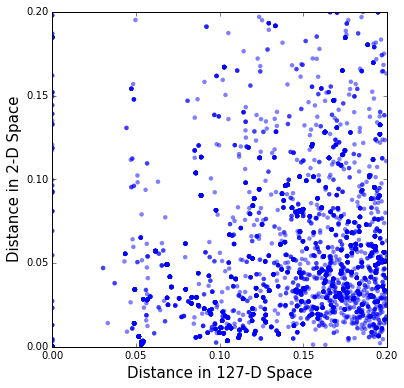

In [7]:
'''
Compare distances before and after multidimensional scaling.
'''
import random

ndists  = 40000
seed    = 321

random.seed(seed)
npoints = len(pos)
out     = []
keep    = set()
ndist1  = 0
while len(out)<ndists:
    idx1 = random.randint(0,npoints-1)
    idx2 = random.randint(0,npoints-1)
    if idx1==idx2: 
        continue
    if idx1>idx2: 
        idx1,idx2=idx2,idx1
    if (idx1,idx2) in keep: 
        continue
    keep.add((idx1,idx2))
    p1 = pos[idx1]
    p2 = pos[idx2]
    v = p1-p2
    d = np.sqrt(v.dot(v))
    out.append((dist[idx2][idx1],d))
    if dist[idx2][idx1] != 1.0:
        ndist1 += 1

print('Number of points with distance not equal to 1: %i' %ndist1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].scatter([x for x,y in out],[y for x,y in out],alpha=0.5,edgecolors='none')
ax[0].set_xlim(0.0,1.0)
ax[0].set_ylim(0.0,2.0)
ax[0].set_xlabel('Distance in 127-D Space', fontsize=15)
ax[0].set_ylabel('Distance in 2-D Space', fontsize=15)

ax[1].hist([y for x,y in out if x==1.], bins=50)
ax[1].set_xlim(0.0,1.6)
ax[1].set_xlabel('Distance in 2-D Space', fontsize=15)
ax[1].set_ylim(0.0,1300.)
ax[1].text(0.45, 1200.0, 'Distance in 127-D Space = 1', fontsize=15)
plt.show()
fig.savefig('intertweet_distances.png', dpi=200)

out     = []
ndistc  = 0
for idx1 in range(npoints-1):
    for idx2 in range(idx1+1,npoints):
        if dist[idx2][idx1] <= 0.2:
            ndistc += 1
            p1      = pos[idx1]
            p2      = pos[idx2]
            v       = p1-p2
            d       = np.sqrt(v.dot(v))
            if d <= 0.2:
                out.append((dist[idx2][idx1],d))

print('Number of points selected for distance plot: %i' %ndistc)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.scatter([x for x,y in out],[y for x,y in out],alpha=0.5,edgecolors='none')
ax.set_xlim(0.0,0.2)
ax.set_ylim(0.0,0.2)
ax.set_xlabel('Distance in 127-D Space', fontsize=15)
ax.set_ylabel('Distance in 2-D Space', fontsize=15)
plt.show()

## K-Means

CPU times: user 1.49 s, sys: 11.7 ms, total: 1.51 s
Wall time: 1.5 s

Example Tweets by Cluster:
Cl. Message                                                                                       Pol.   Subj.
0: "I think I'm going to wear yoga pants to the office tomorrow                               "   0.000  0.000
0: "Yoga Pants So Tight    These 10 Pictures Will Leave You W                                 "  -0.179  0.286
0: "@ms snippety @mamapojo Try losing your jeans to your GF cuz ripped the ass outta her yoga "   0.000  0.000
0: "@Girliegurll: Rules for wearing animal print yoga pants: weigh less than the animal they r"  -0.167  0.067
0: "Depraved And Sexy Babe In Her Tight Black Yoga Pants Got Fucked                           "  -0.111  0.605
0: "Took advantage of the $25 yoga pants sale online @VictoriasSecret andand I want even more!"   0.281  0.450
0: "There is more to yoga than cameltoes in yoga pants  #yoga #yogapants #cameltoe #CamelToeAp"   0.500  0.500
0: "@TheAngryFa

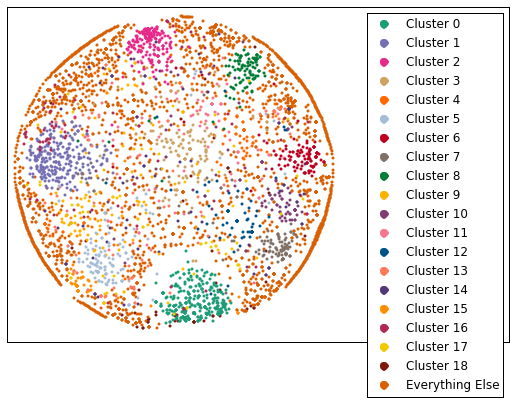

In [77]:
'''
Apply K-means clustering with 20 clusters.  We set the random state in the call
to KMeans so as to get reproducible results.
'''
from   sklearn.cluster import KMeans
from   sklearn.externals import joblib
import pandas as pd
from   __future__ import print_function

compute       = True
num_clusters  = 20
clusters_file = 'results/yoga_tweet_clusters_20.pkl'

if compute:
    km        = KMeans( n_clusters=num_clusters, init='k-means++', max_iter=300, tol=0.0001, random_state=3439 )
    %time       km.fit(tfidf_matrix)
    joblib.dump( km, clusters_file )
else:
    km        = joblib.load( clusters_file )

clusters      = km.labels_.tolist()
yoga_tweets   = { 'tweet': tweets, 'polarity': polarities, 'subjectivity': subjectivities, 'cluster': clusters }
df            = pd.DataFrame(yoga_tweets, index=[clusters], columns=['tweet','polarity','subjectivity','cluster'])

# Create a lookup table to order clusters by decreasing population
clus_pop  = [(cluster,df['cluster'].value_counts()[cluster]) for cluster in range(num_clusters)]
ranks     = [cnum for (cnum,cpop) in sorted(clus_pop,key=lambda x: -x[1])]
ranks     = ranks[1:] + ranks[:1] # ... but put most populous (least interesting) cluster at the end
rank_clus = {ind: ranks[ind] for ind in range(len(ranks))}
clus_rank = {rank: ind for ind,rank in rank_clus.items()}

# For each cluster print some example tweets
print('\nExample Tweets by Cluster:')
print('%s %s %s' %("Cl. Message"," "*85,"Pol.   Subj."))
for cluster in range(num_clusters):
    cfound = 0
    cnum   = rank_clus[cluster]
    for row in df.itertuples():
        index, tweet, pol, subj, cnum0 = row
        if cnum0==cnum:
            print('%i: "%s"  %6.3f  %5.3f' %(cluster,tweet.replace("\n", "").ljust(90)[:90],pol,subj))
            cfound += 1
        if cfound==10:
            print('')
            break

# For each cluster print some properties
grouped1 = df['polarity'].groupby(df['cluster'])
grouped2 = df['subjectivity'].groupby(df['cluster'])
print('\nCluster Properties:')
print('Cluster    Population    Mean Polarity    Mean Subjectivity')
for cluster in range(num_clusters):
    cnum = rank_clus[cluster]
    print('  %2d         %5d         %7.4f          %7.4f' \
          %(cluster,df['cluster'].value_counts()[cnum],grouped1.mean()[cnum],grouped2.mean()[cnum]))

# For each cluster print the top n-grams
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
print("\nTop n-grams per cluster:")
for cluster in range(num_clusters):
    cnum = rank_clus[cluster]
    print("%d:" % cluster, end='')
    for ind in order_centroids[cnum, :11]:
        print(' %s' % ' '.join(vocab[stem] for stem in terms[ind].split(' ')), end=',')
    print(" ")

# Set up cluster visualization
colors              = ['#1b9e77', '#7570b3', '#e7298a', '#cea262', '#ff6800', 
                       '#a6bdd7', '#c10020', '#817066', '#007d34', '#ffb300', 
                       '#803e75', '#f6768e', '#00538a', '#ff7a5c', '#53377a', 
                       '#ff8e00', '#b32851', '#f4c800', '#7f180d', '#d95f02']
num_clusters_toplot = min(20,num_clusters)
clusters_toplot     = range(num_clusters_toplot)
cluster_colors      = {ic: colors[ind] for ind,ic in enumerate(clusters_toplot)}
cluster_names       = {ic: 'Cluster '+str(ic) for ic in range(num_clusters)}
cluster_names[num_clusters_toplot-1] = 'Everything Else'

# Create data frame that has the result of the MDS plus the clusters
df5            = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups         = df5.groupby('label')

# Make plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.margins(0.05) # Add 5% padding to the autoscaling
for cluster, group in groups:
    rnum = clus_rank[cluster]
    if rnum in clusters_toplot:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, alpha=1.0,
                label=cluster_names[rnum], color=cluster_colors[rnum], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
        ax.set_xlim(-0.85,1.7)
        ax.set_ylim(-0.85,0.85)
        
hn, lb = ax.get_legend_handles_labels()
hn = [hn[rank_clus[i]] for i in range(len(hn))]
lb = [lb[rank_clus[i]] for i in range(len(lb))]
ax.legend(hn, lb, numpoints=1, markerscale=3)
plt.show()
fig.savefig('km_clusters_20.png', dpi=200)

## Latent Dirichlet Allocation

In [78]:
'''
Extend tweets with 2-grams and 3-grams, then build a gensim dictionary.
'''
import nltk
from gensim import corpora

def ngrams(tokens, n):
    """Extend a list of tokens with its own space-separated i-grams, where i = 2,...,n."""
    tokens1 = tokens[:]
    if n > 1:
        tokens0 = tokens[:]
        for i in range(2,n+1):
            tokens1.extend([' '.join(a) for a in nltk.ngrams(tokens0,i)])
    return tokens1

# Extend tweets with n-grams.
extended_tweets  = [ngrams(tweet,3) for tweet in filtered_tweets]

# Build dictionary for gensim.
dictionary       = corpora.Dictionary(extended_tweets)
num_below        = int( 0.01 * len(extended_tweets) )
dictionary.filter_extremes(no_below=num_below, no_above=0.80, keep_n=None)
n_terms          = len(dictionary)
n_docs           = len(extended_tweets)

# Print some info.
print(dictionary)
print(' ')
ind = 0
for key,value in sorted(dictionary.token2id.items()):
    if ind%4 != 3:
        print('{0:17} {1:3d} | '.format(key+":",value),end='')
    else:
        print('{0:17} {1:3d}'.format(key+":",value))
    ind += 1

Dictionary(130 unique tokens: [u'summer', u'help', u'pant', u'photo', u'weight loss']...)
 
back:              32 | beach:            113 | beauti:            68 | beginn:            97
best:              37 | better:            12 | bodi:              51 | book:             111
ca:                70 | challeng:         101 | check:            107 | class:            121
come:              56 | day:               23 | even:              38 | ever:              44
everi:             15 | exercis:           13 | feel:              69 | find:               9
first:             65 | fit:               11 | flow:             126 | follow:             8
free:              50 | friend:            95 | get:               16 | girl:              36
go:                 7 | good:              14 | got:               21 | great:             58
gym:               87 | health:            41 | healthi:           62 | help:               1
hot:              110 | hot yoga:          42 | instructor:   

In [100]:
'''
Latent Dirichlet Allocation with Gensim.
We run the algorithm in batch mode (update_every=0).
'''
from gensim import corpora, models, similarities 

recompute        = False
use_tfidf        = False
n_LDA_topics     = 5
n_passes         = 200
seed_weight      = 500 # if seed_weight=1 topics are not seeded
topic_seeds      = {0: ['pant','wear'], 1: ['class','free'], 2: ['medit','mudra'], 3:['hot']}

# Create file name for reading or writing out results
lda_file         = "results/yoga_tweets_lda"+str(n_passes).zfill(3)
if use_tfidf:
    lda_file    += "_tfidf_"+str(n_LDA_topics).zfill(3)
else:
    lda_file    += "_bow_"+str(n_LDA_topics).zfill(3)

# Pre-processing for the case where topics are seeded
if seed_weight != 1:
    lda_file    += "_s"+str(seed_weight).zfill(4)
    
    # Locate the topic seeds in the dictionary and store their integer key in inverse_dict.
    inverse_dict = {value: key for vlist in topic_seeds.values() for key,value in dictionary.items() if value in vlist}
    print(inverse_dict)

    # The eta matrix is n_LDA_topics rows by n_terms columns.  Each row serves as a prior distribution of terms 
    # for the corresponding topic.  Here we increase the prior weight of the seeds.
    eta_matrix  = [[1]*n_terms for _ in range(n_LDA_topics)]
    for topic,seeds in topic_seeds.items():
        for seed in seeds:
            eta_matrix[topic][inverse_dict[seed]] = seed_weight
        
# Create bags-of-words corpus
corpus_bow       = [dictionary.doc2bow(tweet) for tweet in extended_tweets]

# Create Tf-Idf corpus
if use_tfidf:
    tfidf        = models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf[corpus_bow]

# Create LDA corpus
if recompute:
    if seed_weight != 1:
        if use_tfidf:
            %time lda= models.LdaModel( corpus_tfidf, id2word=dictionary, num_topics=n_LDA_topics, \
                                        eta=eta_matrix, update_every=0, passes=n_passes )
        else:
            %time lda= models.LdaModel( corpus_bow, id2word=dictionary, num_topics=n_LDA_topics, \
                                        eta=eta_matrix, update_every=0, passes=n_passes )
    else:
        if use_tfidf:
            %time lda= models.LdaModel( corpus_tfidf, id2word=dictionary, num_topics=n_LDA_topics, \
                                        update_every=0, passes=n_passes )
        else:
            %time lda= models.LdaModel( corpus_bow, id2word=dictionary, num_topics=n_LDA_topics, \
                                        update_every=0, passes=n_passes )
    lda.save(lda_file)
else:
    lda          = models.LdaModel.load(lda_file)

if use_tfidf:
    corpus_lda   = lda[corpus_tfidf]
else:
    corpus_lda   = lda[corpus_bow]

print('In corpus: Number of terms = %i, documents = %i, latent topics = %i' % (n_terms,n_docs,n_LDA_topics))

{u'pant': 2, u'mudra': 116, u'free': 50, u'hot': 110, u'wear': 53, u'medit': 28, u'class': 121}
In corpus: Number of terms = 130, documents = 4779, latent topics = 5


Number of successful document-topic associations: 4779 (0 failure(s))

 0:  0.0288*'day' + 0.0267*'get' + 0.0237*'love' + 0.0227*'fitness' + 0.0196*'practice' + 0.0184*'poses' +
     0.0181*'time' + 0.0173*'today' + 0.0169*'new' + 0.0162*'one' + 0.0154*'mat' + 0.0151*'need' + 0.0146*'come' +
     0.0143*'good' + 0.0141*'body' + 0.0136*'workout' + 0.0133*'try' + 0.0131*'like' + 0.0129*'working' +
     0.0127*'us'

     (Probability sum of displayed n-grams)/(total probability) = 0.347453/1.000000
     Number of documents in plot = 2964

 1:  0.3242*'pants' + 0.2090*'wear' + 0.1456*'yoga pants' + 0.0317*'girls' + 0.0246*'like' + 0.0227*'wear yoga' +
     0.0213*'wear yoga pants' + 0.0195*'going' + 0.0188*'leggings' + 0.0172*'like yoga' + 0.0116*'say' +
     0.0107*'never' + 0.0084*'got' + 0.0081*'would' + 0.0078*'follow' + 0.0065*'look' + 0.0063*'know' +
     0.0062*'think' + 0.0059*'working' + 0.0045*'make'

     (Probability sum of displayed n-grams)/(total probability) = 0.910620/1.00

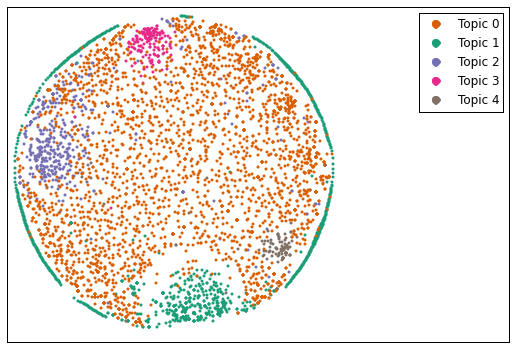

In [103]:
'''
Print out the LDA topics, with their term distributions.
'''
import textwrap

n_LDA_topics = lda.num_topics

# Associate documents with topics, for the visualization.
# Each document is associated with its highest-probability topic, provided that probability is at least prob_min.
prob_min     = 0.0
topics_probs = [sorted(doc,key=lambda x: x[1],reverse=True)[0] if len(doc)>=1 else (n_LDA_topics,0.0) \
                for doc in corpus_lda]
topics       = [topic if prob>=prob_min else n_LDA_topics for (topic,prob) in topics_probs]
nfailures    = topics.count(n_LDA_topics)
print('Number of successful document-topic associations: %i (%i failure(s))\n' %(len(topics)-nfailures,nfailures))

# Count the number of tweets per topic, then order topics by decreasing tweet population
topic_counts = [(ind,topics.count(ind)) for ind in range(n_LDA_topics)]
ranks        = [tnum for (tnum,tcount) in sorted(topic_counts,key=lambda x: -x[1])]
rank_topic   = {ind: ranks[ind] for ind in range(n_LDA_topics)}
topic_rank   = {rank: ind for ind,rank in rank_topic.items()}

# Set up topic color scheme (20 topics maximum)
colors            = ['#d95f02', '#1b9e77', '#7570b3', '#e7298a', '#817066',
                     '#ff6800', '#a6bdd7', '#c10020', '#cea262', '#007d34',
                     '#ffb300', '#803e75', '#f6768e', '#00538a', '#ff7a5c',
                     '#53377a', '#ff8e00', '#b32851', '#f4c800', '#7f180d']
num_topics_toplot = min(20,n_LDA_topics)
topics_toplot     = range(num_topics_toplot)
topic_colors      = {ic: colors[ind] for ind,ic in enumerate(topics_toplot)}

# Print a list of the topics
for itopic in range(n_LDA_topics):
    tnum       = rank_topic[itopic]
    out_string = "{:2d}".format(itopic)+": "
    pshown     = 0.0
    for ind,(prob,n_gram_stems) in enumerate(lda.show_topic(tnum, topn=20)):
        n_gram_words = ' '.join([(vocab[stem] if stem in vocab else '['+stem+']') for stem in n_gram_stems.split(' ')])
        pshown      += prob
        if ind > 0:
            out_string += " + "+"{:.4f}".format(prob)+"*'"+n_gram_words+"'"
        else:
            out_string += " "+"{:.4f}".format(prob)+"*'"+n_gram_words+"'"
    print(textwrap.fill(out_string, width=115, subsequent_indent=' '*5))
    ptotal = sum([prob for (prob,n_gram_stems) in lda.show_topic(tnum,topn=n_terms)])
    print("\n     (Probability sum of displayed n-grams)/(total probability) = %f/%f" % (pshown,ptotal))
    print("     Number of documents in plot = %i\n" % topics.count(tnum))

topic_names  = {ic: 'Topic '+str(ic) for ic in range(n_LDA_topics)}

# Create data frame that has the result of the MDS and the LDA
df_lda       = pd.DataFrame(dict(x=xs, y=ys, label=topics)) 
groups_lda   = df_lda.groupby('label')

# Make plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.margins(0.05) # Add 5% padding to the autoscaling
for topic, group in groups_lda:
    rnum = topic_rank[topic]
    if rnum in topics_toplot:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, alpha=1.0, 
                label=topic_names[rnum], color=topic_colors[rnum], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
        ax.set_xlim(-0.85,1.7)
        ax.set_ylim(-0.85,0.85)
        
hn, lb = ax.get_legend_handles_labels()
hn = [hn[rank_topic[i]] for i in range(len(hn))]
lb = [lb[rank_topic[i]] for i in range(len(lb))]
ax.legend(hn, lb, numpoints=1, markerscale=3)
plt.show()
fig.savefig('topics_lda_bow.png', dpi=200)